python: 3.8.5  
tensorflow: 2.4.1

In [1]:
import tensorflow as tf

In [2]:
import sys
print('python:', sys.version)
print('tensorflow:', tf.__version__)

python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
tensorflow: 2.4.1


## Импорт данных

Labels: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

getData: получает множество изображений и их метки по указанному пути 'path' к папке с категориями.

In [3]:
def getData(path):
    folders = tf.io.gfile.listdir(path)
    allFiles = []

    for i in range(len(folders)):
        files = tf.io.gfile.listdir(path + '\\' + folders[i])
        allFiles.extend(list(map(lambda f: [path + '\\' + folders[i] + '\\' + f, i], files)))

    images = []
    labels = []

    for file, i in allFiles:
        img_raw = tf.io.read_file(file)
        img = tf.io.decode_image(img_raw, channels=3)
        img = tf.image.resize(img, [28,28], method='bilinear')
        img = img / 255
        images.append(img)
        labels.append(i)
    
    return tf.stack(images), tf.one_hot(labels, 6)

In [4]:
train_data, train_labels = getData('data\seg_train\seg_train')

In [5]:
test_data, test_labels = getData('data\seg_test\seg_test')

In [6]:
pred_data = getData('data\seg_pred')[0]

Перемешиваем данные для последующего разделения на выборку для обучения и валидации.

In [7]:
indices = tf.range(start=0, limit=tf.shape(train_data)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

shuffled_train_data = tf.gather(train_data, shuffled_indices)
shuffled_train_labels = tf.gather(train_labels, shuffled_indices)

## Подготовка модели

Два сверточных слоя попарно с последующим пулингом + 'Dropout' для понижения переобучения модели.  
На вход, по условию, подаем изображения размерности 28x28x3.

In [31]:
from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential()
model.add(keras.Input(shape=(28, 28, 3)))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                

## Обучение модели
Выделяем 20% выборки для валидации. После ~70 эпох модель начинает переобучатся без улучшения результата на валидационой выборке.

In [32]:
%%time
training_history = model.fit(shuffled_train_data, shuffled_train_labels, batch_size=150, epochs=70, validation_split=0.2)

Epoch 1/70
75/75 [==============================] - 5s 55ms/step - loss: 1.6710 - accuracy: 0.2844 - val_loss: 1.2093 - val_accuracy: 0.5347
Epoch 2/70
75/75 [==============================] - 4s 52ms/step - loss: 1.2321 - accuracy: 0.5118 - val_loss: 1.0597 - val_accuracy: 0.5949
Epoch 3/70
75/75 [==============================] - 4s 52ms/step - loss: 1.0671 - accuracy: 0.5770 - val_loss: 0.9559 - val_accuracy: 0.6537
Epoch 4/70
75/75 [==============================] - 4s 51ms/step - loss: 1.0062 - accuracy: 0.6190 - val_loss: 0.9037 - val_accuracy: 0.6733
Epoch 5/70
75/75 [==============================] - 4s 51ms/step - loss: 0.9471 - accuracy: 0.6458 - val_loss: 0.8743 - val_accuracy: 0.6933
Epoch 6/70
75/75 [==============================] - 4s 52ms/step - loss: 0.9122 - accuracy: 0.6541 - val_loss: 0.8696 - val_accuracy: 0.6911
Epoch 7/70
75/75 [==============================] - 4s 52ms/step - loss: 0.8967 - accuracy: 0.6638 - val_loss: 0.8298 - val_accuracy: 0.7029
Epoch 8/70
75

Epoch 59/70
75/75 [==============================] - 4s 50ms/step - loss: 0.5655 - accuracy: 0.7885 - val_loss: 0.5889 - val_accuracy: 0.7944
Epoch 60/70
75/75 [==============================] - 4s 49ms/step - loss: 0.5658 - accuracy: 0.7964 - val_loss: 0.5930 - val_accuracy: 0.7912
Epoch 61/70
75/75 [==============================] - 4s 50ms/step - loss: 0.5731 - accuracy: 0.7942 - val_loss: 0.5831 - val_accuracy: 0.7941
Epoch 62/70
75/75 [==============================] - 4s 49ms/step - loss: 0.5490 - accuracy: 0.7994 - val_loss: 0.5816 - val_accuracy: 0.7959
Epoch 63/70
75/75 [==============================] - 4s 48ms/step - loss: 0.5576 - accuracy: 0.7960 - val_loss: 0.5811 - val_accuracy: 0.7959
Epoch 64/70
75/75 [==============================] - 4s 50ms/step - loss: 0.5659 - accuracy: 0.7914 - val_loss: 0.5919 - val_accuracy: 0.7905
Epoch 65/70
75/75 [==============================] - 4s 48ms/step - loss: 0.5456 - accuracy: 0.8029 - val_loss: 0.5950 - val_accuracy: 0.7909
Epoch 

In [33]:
model.save('test_model')

INFO:tensorflow:Assets written to: test_model\assets


## Оценка модели
Загружаем ранее сохраненную модель, оцениваем на тестовой выборке.

In [34]:
model = tf.keras.models.load_model('test_model')

In [35]:
loss, acc = model.evaluate(test_data, test_labels)

print('\nloss', loss)
print('accuracy', acc)

94/94 [==============================] - 1s 4ms/step - loss: 0.6023 - accuracy: 0.7843

loss 0.6023237109184265
accuracy 0.784333348274231


## Предсказание
Высчитываем результат модели на наборе 'seg_pred'

In [36]:
predictions = model.predict(pred_data)
print(predictions)

[[1.01354331e-01 3.75094935e-02 5.80441629e-05 1.67522827e-04
  7.59194954e-04 8.60151470e-01]
 [3.43280733e-02 4.46914928e-03 5.13258092e-02 6.36881113e-01
  2.68052220e-01 4.94375639e-03]
 [1.69966295e-01 3.00828293e-02 2.68330518e-06 1.16816568e-06
  3.28925526e-04 7.99618125e-01]
 ...
 [5.61627420e-03 6.45615044e-04 1.12790436e-01 2.02272043e-01
  6.73773646e-01 4.90201730e-03]
 [8.30877616e-06 9.99964714e-01 2.51949564e-06 4.31295348e-06
  4.22494765e-07 1.96839737e-05]
 [9.92073491e-02 1.37397274e-03 9.84390063e-05 2.04786443e-06
  8.56379280e-04 8.98461819e-01]]


### Дополнение
Смотрим результат предсказания для случайного изображения из набора 'seg_pred'

In [37]:
import numpy as np
import matplotlib.pyplot as plt

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
[[0.00128357 0.00333826 0.06875461 0.6122541  0.31043783 0.00393167]]

predicted: mountain 
value: 0.6122541


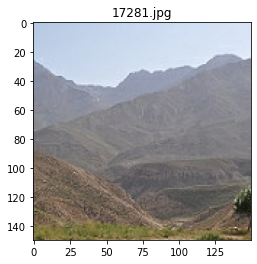

In [47]:
from random import randint
index = randint(0, 7300)

files = tf.io.gfile.listdir('data\seg_pred\seg_pred')

img_path = 'data\\seg_pred\\seg_pred\\' + files[index]
img_raw = tf.io.read_file(img_path)
img = tf.io.decode_image(img_raw)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [150,150])

plt.title(files[index])
plt.imshow(img)

img_raw = tf.io.read_file(img_path)
img = tf.io.decode_image(img_raw, channels=3)
img = tf.image.resize(img, [28,28], method='bilinear')
img = img / 255

labels = tf.io.gfile.listdir('data\seg_train\seg_train')
prediction = model.predict(tf.stack([img]))

print(labels)
print(prediction)

print('\npredicted:', labels[prediction.argmax()], '\nvalue:', prediction.max())